Imports

In [41]:
import torch
import lightning as L
from diffusers import DDIMScheduler, UNet2DModel
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda")

In [4]:
class DiffusionModel(L.LightningModule):
    def __init__(self, lr=1e-1, num_train_timesteps=1000):
        super().__init__()
        self.save_hyperparameters()
        self.net = UNet2DModel()
        self.scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps, beta_schedule="linear")
        self.loss_fn = nn.MSELoss()

    def forward(self, x, timesteps):
        return self.net(x, timesteps).sample

    def training_step(self, batch, batch_idx):
        x, _ = batch  # Ignore labels if they exist
        timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (x.size(0),), device=self.device)
        noise = torch.rand_like(x).to(self.device)
        noisy_images = self.scheduler.add_noise(x, noise, timesteps)

        pred = self(noisy_images, timesteps)  # Model forward pass
        loss = self.loss_fn(pred, x)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (x.size(0),), device=self.device)
        outputs = self(x, timesteps)
        loss = self.loss_fn(outputs, x)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=self.hparams.lr)
        return optimizer

Load model

In [55]:
checkpoint_path = "/mnt/raid/home/ajarry/data/outputs_lightning/output_20250303_141543/model.pth"
model = DiffusionModel()
state_dict = torch.load(checkpoint_path)
model.load_state_dict(state_dict, strict=False)
model = model.to(device)


Sampling and display

In [61]:
# Define the scheduler (make sure it matches the one used in training)
scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# Set up sampling parameters
image_size = (1, 3, 256, 256)  # Adjust shape (batch, channels, height, width)
num_inference_steps = 50  # Can be reduced for faster generation
scheduler.set_timesteps(num_inference_steps)

# Start with pure noise
device = "cuda" if torch.cuda.is_available() else "cpu"
noisy_image = torch.randn(image_size).to(device)

# Sample timesteps
timesteps = scheduler.timesteps.to(device)

# Reverse process (denoising)
with torch.no_grad():
    for t in timesteps:
        # Predict noise
        noise_pred = model(noisy_image, t.unsqueeze(0))
        
        # Remove noise using scheduler
        noisy_image = scheduler.step(noise_pred, t, noisy_image).prev_sample


Saving result

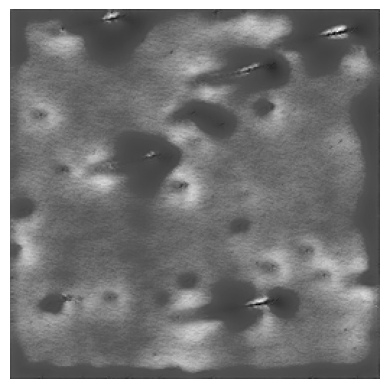

In [62]:

# Convert to image format
generated_image = noisy_image.cpu().numpy().squeeze()

# Show the image
plt.imshow(generated_image[0], cmap="gray")
plt.axis("off")
plt.show()

In [60]:
# generated_image.save("generated_sample.png")